In [53]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
X = np.load('X.npy')
y = np.load('y.npy')

In [3]:
X.shape, y.shape

((5959, 224, 224, 3), (5959,))

In [4]:
# Split the data into training and testing sets with Shuffle
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [5]:
X_train.shape, X_test.shape

((4767, 224, 224, 3), (1192, 224, 224, 3))

In [6]:
y_train.shape, y_test.shape

((4767,), (1192,))

### Transfer Learning

In [7]:
import tensorflow as tf

In [8]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [9]:
VGG16 = tf.keras.applications.VGG16(
            include_top=False,
            weights="imagenet",
            input_shape=X_train[0].shape
        )

VGG16.trainable = False

2024-01-20 14:43:30.547995: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-01-20 14:43:30.548014: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-01-20 14:43:30.548020: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-01-20 14:43:30.548268: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-20 14:43:30.548610: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [10]:
VGG16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [11]:
# Data Augmentation

data_augmentation = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,        # Rotate the image within a range of degrees
    width_shift_range=0.2,    # Shift the image along its width
    height_shift_range=0.2,   # Shift the image along its height
    shear_range=0.2,          # Shear transformation
    zoom_range=0.2,           # Zoom in/out within the image
    horizontal_flip=True,     # Flip the image horizontally
    fill_mode='nearest'       # Strategy to fill newly created pixels
)

train_generator = data_augmentation.flow(X_train, y_train, batch_size=32)

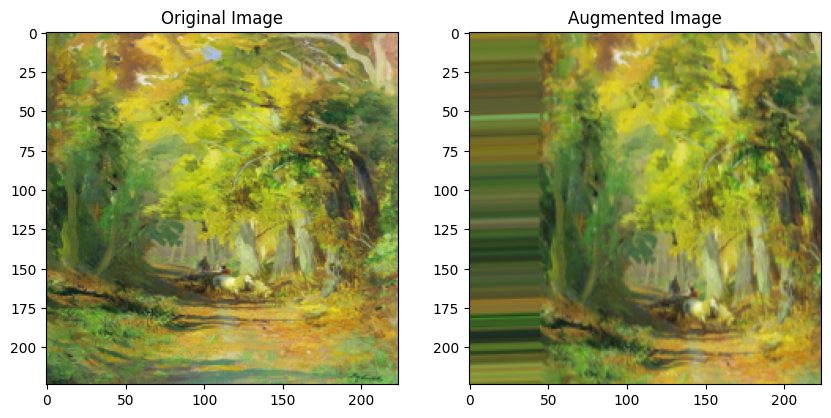

In [76]:
image_batch = np.expand_dims(X_train[0], axis=0)

# Generating the augmented images
augmented_image_batch = data_augmentation.flow(image_batch, batch_size=1)
augmented_image = next(augmented_image_batch)[0]

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(X_train[0])
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(augmented_image)
plt.title('Augmented Image')

plt.show()


In [74]:
ResNet50V2 = tf.keras.applications.ResNet50V2(
            include_top=False,
            weights="imagenet",
            input_shape=X_train[0].shape
        )

ResNet50V2.trainable = False

In [20]:
ResNet50V2.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                                                                                         

In [12]:
flatten_layer = tf.keras.layers.Flatten()
dense_layer_1 = tf.keras.layers.Dense(64, activation='relu')
dense_layer_2 = tf.keras.layers.Dense(32, activation='relu')
dense_layer_3 = tf.keras.layers.Dense(16, activation='relu')
prediction_layer = tf.keras.layers.Dense(5)


model = tf.keras.models.Sequential([
    VGG16,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    dense_layer_3,
    prediction_layer
])

model.compile(
    optimizer = 'adam', 
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = ['acc']
)

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 64)                1605696   
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 5)                 85        
                                                                 
Total params: 16323077 (62.27 MB)
Trainable params: 1608

In [14]:
model.fit(train_generator, epochs=20, batch_size=32)

Epoch 1/20


2024-01-20 14:44:25.167634: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


149/149 [==============================] - 44s 286ms/step - loss: 3.4962 - acc: 0.3413
Epoch 2/20
149/149 [==============================] - 43s 285ms/step - loss: 1.8783 - acc: 0.4265
Epoch 3/20
149/149 [==============================] - 43s 285ms/step - loss: 1.4639 - acc: 0.4756
Epoch 4/20
149/149 [==============================] - 42s 284ms/step - loss: 1.3659 - acc: 0.5165
Epoch 5/20
149/149 [==============================] - 43s 285ms/step - loss: 1.3600 - acc: 0.5253
Epoch 6/20
149/149 [==============================] - 43s 285ms/step - loss: 1.2291 - acc: 0.5500
Epoch 7/20
149/149 [==============================] - 43s 285ms/step - loss: 1.1892 - acc: 0.5511
Epoch 8/20
149/149 [==============================] - 43s 285ms/step - loss: 1.3589 - acc: 0.5267
Epoch 9/20
149/149 [==============================] - 43s 286ms/step - loss: 1.1622 - acc: 0.5733
Epoch 10/20
149/149 [==============================] - 43s 286ms/step - loss: 1.2977 - acc: 0.5494
Epoch 11/20
149/149 [=========

In [15]:
score, acc = model.evaluate(X_test, y_test)
print("Test loss: ", score)
print("Test accuracy:", acc)

38/38 [==============================] - 12s 277ms/step - loss: 1.1173 - acc: 0.6032
Test loss:  1.1172962188720703
Test accuracy: 0.6031879186630249


In [22]:
flatten_layer = tf.keras.layers.Flatten()
dense_layer_1 = tf.keras.layers.Dense(64, activation='relu')
dense_layer_2 = tf.keras.layers.Dense(32, activation='relu')
dense_layer_3 = tf.keras.layers.Dense(16, activation='relu')
prediction_layer = tf.keras.layers.Dense(5)


model2 = tf.keras.models.Sequential([
    
    ResNet50V2,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    dense_layer_3,
    prediction_layer
])

model2.compile(
    optimizer = 'adam', 
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = ['acc']
)

In [23]:
model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 flatten_1 (Flatten)         (None, 100352)            0         
                                                                 
 dense_4 (Dense)             (None, 64)                6422592   
                                                                 
 dense_5 (Dense)             (None, 32)                2080      
                                                                 
 dense_6 (Dense)             (None, 16)                528       
                                                                 
 dense_7 (Dense)             (None, 5)                 85        
                                                                 
Total params: 29990085 (114.40 MB)
Trainable params: 6

In [24]:
model2.fit(train_generator, epochs=30, batch_size=32)

Epoch 1/30
149/149 [==============================] - 28s 181ms/step - loss: 23.7093 - acc: 0.3990
Epoch 2/30
149/149 [==============================] - 27s 179ms/step - loss: 14.0607 - acc: 0.4577
Epoch 3/30
149/149 [==============================] - 27s 179ms/step - loss: 12.4786 - acc: 0.4615
Epoch 4/30
149/149 [==============================] - 27s 179ms/step - loss: 9.0075 - acc: 0.5242
Epoch 5/30
149/149 [==============================] - 27s 179ms/step - loss: 9.6067 - acc: 0.5347
Epoch 6/30
149/149 [==============================] - 27s 178ms/step - loss: 10.3859 - acc: 0.5299
Epoch 7/30
149/149 [==============================] - 27s 179ms/step - loss: 8.5304 - acc: 0.5437
Epoch 8/30
149/149 [==============================] - 27s 179ms/step - loss: 8.1169 - acc: 0.5607
Epoch 9/30
149/149 [==============================] - 27s 179ms/step - loss: 7.0256 - acc: 0.5773
Epoch 10/30
149/149 [==============================] - 27s 179ms/step - loss: 7.5486 - acc: 0.5737
Epoch 11/30
149

In [25]:
score, acc = model2.evaluate(X_test, y_test)
print("Test loss: ", score)
print("Test accuracy:", acc)

38/38 [==============================] - 9s 192ms/step - loss: 21.0042 - acc: 0.5336
Test loss:  21.004167556762695
Test accuracy: 0.5335570573806763


In [28]:
model.save('VGG16_ArtStyleClass.keras')

In [29]:
model2.save('ResNet50V2_ArtStyleClass.keras')

### Model Performance

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

#### Confusion Matrix

In [37]:
# Confusion matrix for VGG16
predictions_VGG16 = model.predict(X_test)
predicted_classes = np.argmax(predictions_VGG16, axis=1)

cm = confusion_matrix(y_test, predicted_classes)

38/38 [==============================] - 12s 316ms/step


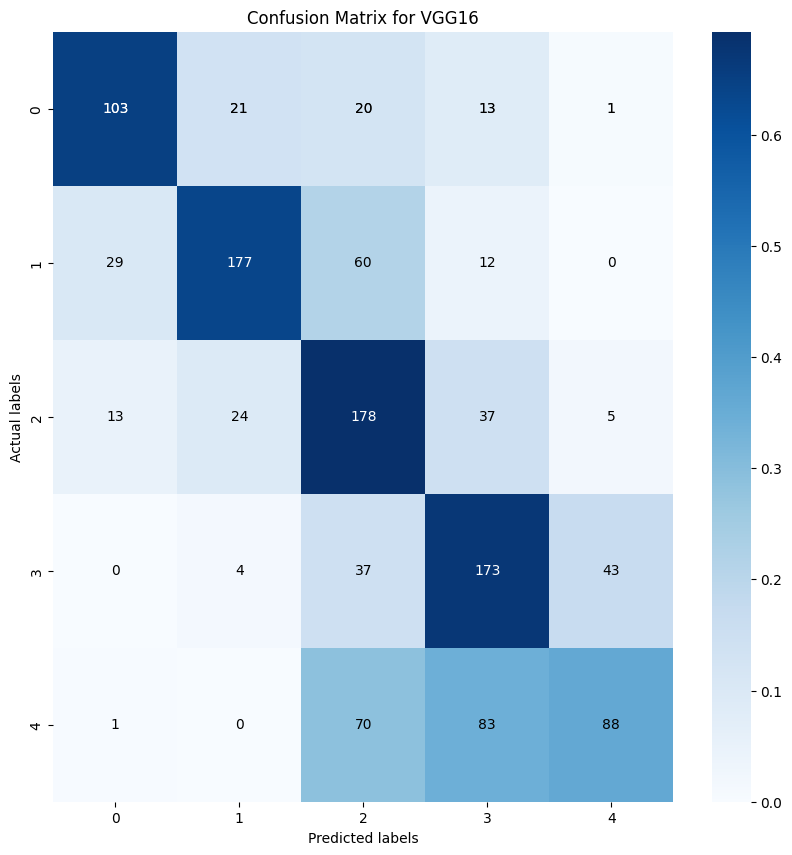

In [38]:
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 10))
hm = sns.heatmap(cm_normalized, annot=cm, fmt="d", cmap='Blues')

# Loop over data dimensions and create text annotations with appropriate colors
for i in range(cm_normalized.shape[0]):
    for j in range(cm_normalized.shape[1]):
        hm.text(j+0.5, i+0.5, cm[i, j],
                 ha="center", va="center",
                 color="white" if cm_normalized[i, j] > 0.5 else "black")

plt.ylabel('Actual labels')
plt.xlabel('Predicted labels')
plt.title('Confusion Matrix for VGG16')
plt.show()

In [39]:
# Confusion matrix for ResNet50V2
predictions_ResNet = model2.predict(X_test)
predicted_classes = np.argmax(predictions_ResNet, axis=1)

cm = confusion_matrix(y_test, predicted_classes)

38/38 [==============================] - 7s 188ms/step


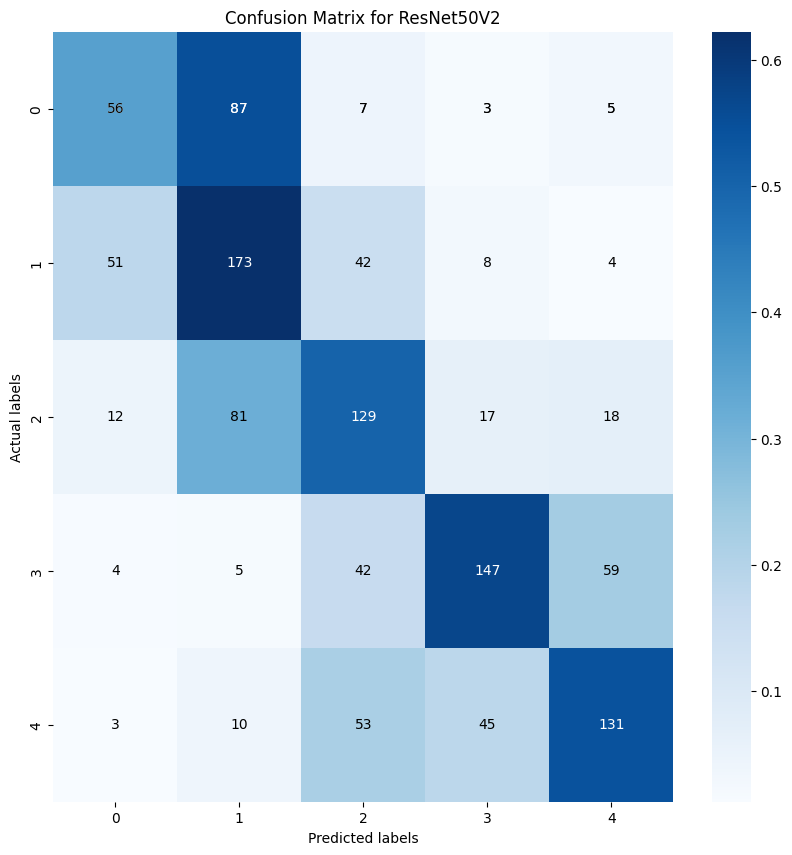

In [40]:
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 10))
hm = sns.heatmap(cm_normalized, annot=cm, fmt="d", cmap='Blues')

# Loop over data dimensions and create text annotations with appropriate colors
for i in range(cm_normalized.shape[0]):
    for j in range(cm_normalized.shape[1]):
        hm.text(j+0.5, i+0.5, cm[i, j],
                 ha="center", va="center",
                 color="white" if cm_normalized[i, j] > 0.5 else "black")

plt.ylabel('Actual labels')
plt.xlabel('Predicted labels')
plt.title('Confusion Matrix for ResNet50V2')
plt.show()

### Class Activation Maps

In [45]:
# 1. Modify the model
# Remove Flatten layer and add GlobalAveragePooling2D
dense_layer_1_modified = tf.keras.layers.Dense(64, activation='relu', input_shape=(2048,))

model_cam = tf.keras.models.Sequential([
    ResNet50V2,
    tf.keras.layers.GlobalAveragePooling2D(),
    dense_layer_1_modified,
    dense_layer_2,
    dense_layer_3,
    prediction_layer
])

# 2. Predict with the modified model
# Replace X_test with your test data
predictions = model_cam.predict(X_test)
predicted_class = np.argmax(predictions, axis=1)

38/38 [==============================] - 8s 189ms/step
